In [1]:
#HMC method
using Plots
using StatsBase
using Random
using Printf
using Distributions
using BenchmarkTools
using QuadGK
using SpecialFunctions
using Zygote

  1.577768 seconds (55.41 M allocations: 1.049 GiB, 6.42% gc time, 10.11% compilation time)


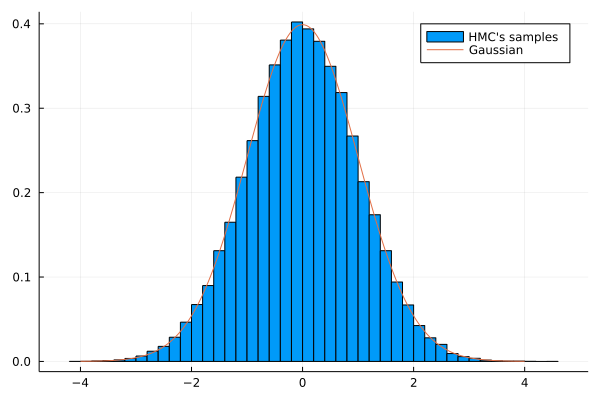

In [2]:
# Generating Gaussian distribution (1-dim) by using HMC method

# # of configurations
n_config = 1_00_000

# size of a configuration
n_size = 1

# # of step of Leapfrog method
n_tau = 100

# time period of Hamilton equation
τ = 5.0

function S(x)
    sum(0.5*x[i]^2 for i=1:n_size)
end

function dSdx(x,k)
    return x
end

function H(x,p)
    K = sum(p[i]^2 for i=1:n_size)
    return S(x) + 0.5*K
end

#１変数更新のHMC法
function HMC_1dim(x)
        #初期化
        p_ini = rand(Normal(0,1),n_size)
        p_fin = zeros(n_size)
        x_ini = zeros(n_size)
        x_fin = zeros(n_size)
    
        #初期配位を保存
        for i=1:n_size x_ini[i] = x[i] end
    
        #初期配位のハミルトニアンを計算
        H_ini = H(x_ini,p_ini)
    
        #リープフロッグで時間発展
        leapfrog!(x,p_ini)
    
        #時間発展後の配位を保存
        for i=1:n_size x_fin[i] = x[i]; p_fin[i] = p_ini[i] end
    
        #時間発展後のハミルトニアンを計算
        H_fin = H(x_fin,p_fin)
    
        #Metropolis check
        r=rand()
        if r<exp(H_ini - H_fin)
            for i=1:n_size x[i] = x_fin[i] end
        else
            for i=1:n_size x[i] = x_ini[i] end
        end
end

#x,pをリープフロッグ法で更新する．
function leapfrog!(x,p)
    Δτ  = τ/n_tau 
    p0  = 0.0
    p1  = 0.0
    x05 = 0.0
    x15 = 0.0
    for k=1:n_size
        #initial setting : τ0
        p0  = p[k]
        x05 = x[k] + p0 * 0.5*Δτ
    
        #(n-1)step : τ0 -> τn-1 
        for i=1:n_tau-1
            p1  = p0 - dSdx(x05,k)*Δτ
            x15 = x05 + p1*Δτ
        
            p0  = p1
            x05 = x15
        end
    
        #final step : τn-1 -> τn
        p_end = p1 - dSdx(x15,k)*Δτ
        x_end = x15 + p_end*0.5*Δτ
        
        x[k]  = x_end
        p[k]  = p_end
    end
end

""" main """
#set of configurations
Ω = zeros(n_config)

#configuration
x = zeros(n_size)

@time for j=1:n_config
    HMC_1dim(x)
    Ω[j] = x[1]
end

Ω

gauss(x) = exp(-0.5*x^2)/sqrt(2*pi)
xr = range(-4,4,length=10001)

plot(Ω,st=:histogram,nbins=50,norm=:pdf,label="HMC's samples")
plot!(xr,gauss.(xr),label="Gaussian")